<a href="https://colab.research.google.com/github/giriharan007/CNN-using-pytorch/blob/main/CNN_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix


In [2]:
#convert MNIST images(2D) into a tensors of 4D(no.of images,height,width,colour channel)
tansform = transforms.ToTensor()

In [3]:
#train data (root='/cnn_data' is the url where dataset have been download and save)
train_data = datasets.MNIST(root='/cnn_data',train=True,download=True,transform=tansform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17654994.50it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 494930.37it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4465331.09it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4861068.84it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [4]:
#test data
test_data = datasets.MNIST(root='/cnn_data',train=False,download=True,transform=tansform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:

#create an batch size
train_loader = DataLoader(train_data,batch_size=15,shuffle=True)
test_loader = DataLoader(test_data,batch_size=15,shuffle=False)

In [8]:
#define CNN Model
#describe convolutional layer we initialize 2 convolutional layer
conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)
conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)

In [9]:
#grab 1 MNIST IMAGE
for i,(X_Train,y_train) in enumerate(train_data):
    break

In [10]:
X_Train.shape

torch.Size([1, 28, 28])

In [11]:
#change 4D Image
x = X_Train.reshape(1,1,28,28)

In [12]:
x.shape

torch.Size([1, 1, 28, 28])

In [13]:
#perform our first convolution
x = F.relu(conv1(x))

In [14]:
#1=single image,6=kernal or filters,26x26=size of img(note:the upside img size is 28x28 now is 26x26 bcoz it take padding default)
x.shape

torch.Size([1, 6, 26, 26])

In [15]:
#pass through pooling layer
x=F.max_pool2d(x,2,2) #x=img,2x2=is kernal size of 2

In [16]:

#26x26/2=13x13 due to pooling
x.shape

torch.Size([1, 6, 13, 13])

In [17]:
#do 2nd convolutional layer
x=F.relu(conv2(x))

In [18]:
x.shape

torch.Size([1, 16, 11, 11])

In [19]:
x=F.max_pool2d(x,2,2)

In [20]:
x.shape

torch.Size([1, 16, 5, 5])

In [21]:
#model class
class convolutionalNetwork(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)
       self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)
#fully connected layer
       self.fc1 = nn.Linear(5*5*16,120) #it above x.shape and 120=output
       self.fc2 = nn.Linear(120,84) #120=is the output of above fc1
       self.fc3 = nn.Linear(84,10)

   def forward(self,X):
    X=F.relu(self.conv1(X))
    X=F.max_pool2d(X,2,2)
    X=F.relu(self.conv2(X))
    X=F.max_pool2d(X,2,2)

    #review to flattern in out
    X=X.view(-1,5*5*16) #-1 that we can vary the batch size

    #fully connected layers
    X=F.relu(self.fc1(X))
    X=F.relu(self.fc2(X))
    X=self.fc3(X)
    return F.log_softmax(X,dim=1)


In [22]:
#create an instance of our model
torch.manual_seed(42)
model = convolutionalNetwork()
model

convolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
#loss fun
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)#smaller learing rate ,it take longer training

In [24]:
#we cheack how long it takes
import time
start_time = time.time() #start time

#declare some variables
epochs=5
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

#for loop for epochs
for i in range(epochs):
  trn_corr=0
  tst_corr=0

  #training
  for b,(X_train,y_train) in enumerate(train_loader):
    b+=1
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)
    prediction = torch.max(y_pred.data,1)[1]#add up the no.of correct prediction.[1]= indexed in first point
    batch_corr= (prediction==y_train).sum() #how many we got crt from this batch,True=1,False=0 and sum those
    trn_corr += batch_corr #keep track as we go along training

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

   #print result
    if b%600==0:
      print(f"epoch:{i},batch: {b} loss: {loss.item()}")

  train_losses.append(loss)
  train_correct.append(trn_corr)

  #test
  with torch.no_grad():#no gradient so we don't update weight and biases with test
    for b,(X_test,y_test) in enumerate(test_loader):
      y_val = model(X_test)
      loss = criterion(y_val,y_test)
      prediction = torch.max(y_val.data,1)[1]#add up crt prediction
      tst_corr += (prediction==y_test).sum()

  test_losses.append(loss)
  test_correct.append(tst_corr)

currrent_time=time.time()
total_time=currrent_time-start_time
print(f"training time took:{total_time/60} minutes")


epoch:0,batch: 600 loss: 0.27575549483299255
epoch:0,batch: 1200 loss: 0.8045499920845032
epoch:0,batch: 1800 loss: 0.07173299044370651
epoch:0,batch: 2400 loss: 0.07981591671705246
epoch:0,batch: 3000 loss: 0.08505412191152573
epoch:0,batch: 3600 loss: 0.010764223523437977
epoch:1,batch: 600 loss: 0.017870334908366203
epoch:1,batch: 1200 loss: 0.0009766991715878248
epoch:1,batch: 1800 loss: 0.32685592770576477
epoch:1,batch: 2400 loss: 0.0005851874011568725
epoch:1,batch: 3000 loss: 0.004059133119881153
epoch:1,batch: 3600 loss: 0.0024177744053304195
epoch:2,batch: 600 loss: 7.858804747229442e-05
epoch:2,batch: 1200 loss: 0.015890827402472496
epoch:2,batch: 1800 loss: 0.0102665601298213
epoch:2,batch: 2400 loss: 0.011516104452311993
epoch:2,batch: 3000 loss: 0.06937242299318314
epoch:2,batch: 3600 loss: 0.0008150379871949553
epoch:3,batch: 600 loss: 0.016574857756495476
epoch:3,batch: 1200 loss: 0.0018926981138065457
epoch:3,batch: 1800 loss: 0.0011580873979255557
epoch:3,batch: 2400 

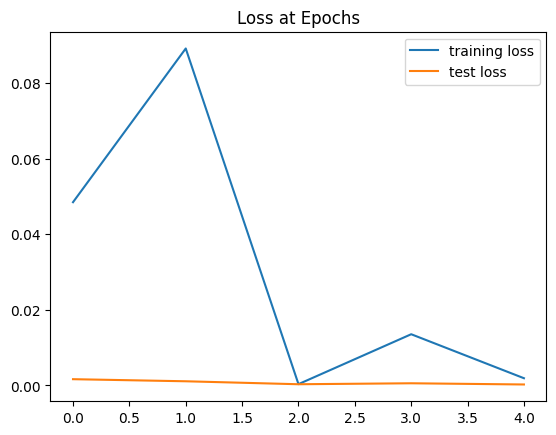

In [29]:
#graph the loss epochs
#train_losses = [t.item() for t in train_losses]
#test_losses = [t.item() for t in test_losses]
plt.plot(train_losses,label='training loss')
plt.plot(test_losses,label='test loss')
plt.title('Loss at Epochs')
plt.legend()

<function matplotlib.pyplot.legend(*args, **kwargs)>

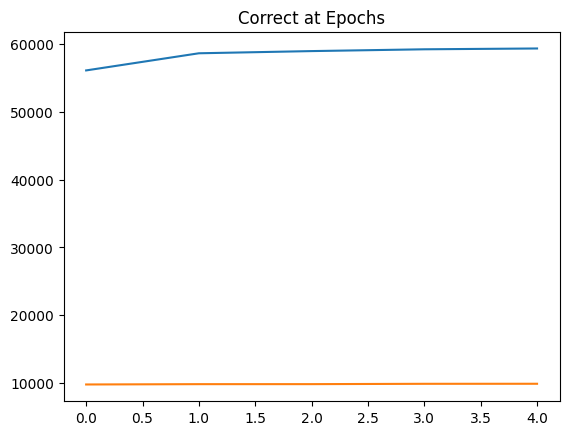

In [30]:
#graph for acc
#train_correct = [tc.item() for tc in train_correct]
#test_correct = [tc.item() for tc in test_correct]
plt.plot(train_correct,label='training correct')
plt.plot(test_correct,label='test correct')
plt.title('Correct at Epochs')
plt.legend

In [31]:
#see actual no how many correct
test_load_everything= DataLoader(test_data,batch_size=1000,shuffle=False)

In [32]:
with torch.no_grad():
  correct=0
  for X_test,y_test in test_load_everything:
      y_val = model(X_test)
      prediction = torch.max(y_val,1)[1]
      correct += (prediction==y_test).sum().item()

In [33]:
correct

9873

In [34]:
#grab the image from test_data
test_data[1735]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [35]:
#grab the data
test_data[1735][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [36]:
#reshape
test_data[1735][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

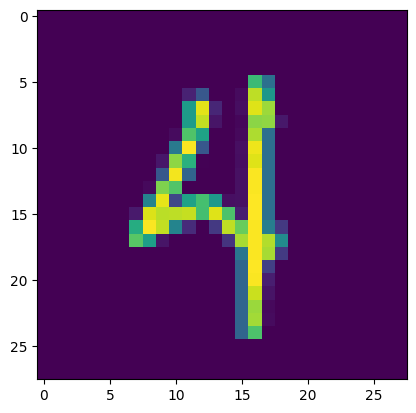

In [37]:
plt.imshow(test_data[1735][0].reshape(28,28))

In [38]:
#pass the image through our model
model.eval()
with torch.no_grad():
  new_image = test_data[1735][0].view(1,1,28,28)
  output = model(new_image)

In [39]:
output

tensor([[-1.8164e+01, -1.1738e+01, -1.0005e+01, -1.5534e+01, -1.3243e-04,
         -1.6849e+01, -1.2221e+01, -1.1665e+01, -1.0496e+01, -1.0180e+01]])

In [40]:
output.argmax()

tensor(4)